In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier 


# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

/home/ds_magico/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ds_magico/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.weight_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_csv('./train.csv')
test =  pd.read_csv('./test.csv')

data = [test, train]
df_1 = pd.concat(data)
df_1.columns = ['Age', 'Cabin', 'Embarked', 'Fare' ,'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket']
df_1 = df_1.loc[:, ['PassengerId', 'Name', 'Pclass', 'Sex', 'Parch', 'SibSp', 'Survived', 'Ticket', 'Age', 'Cabin', 'Fare', 'Embarked']]
# df_1 = df_1.reset_index()
# df_1 = df_1.drop(columns='index')

/home/ds_magico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


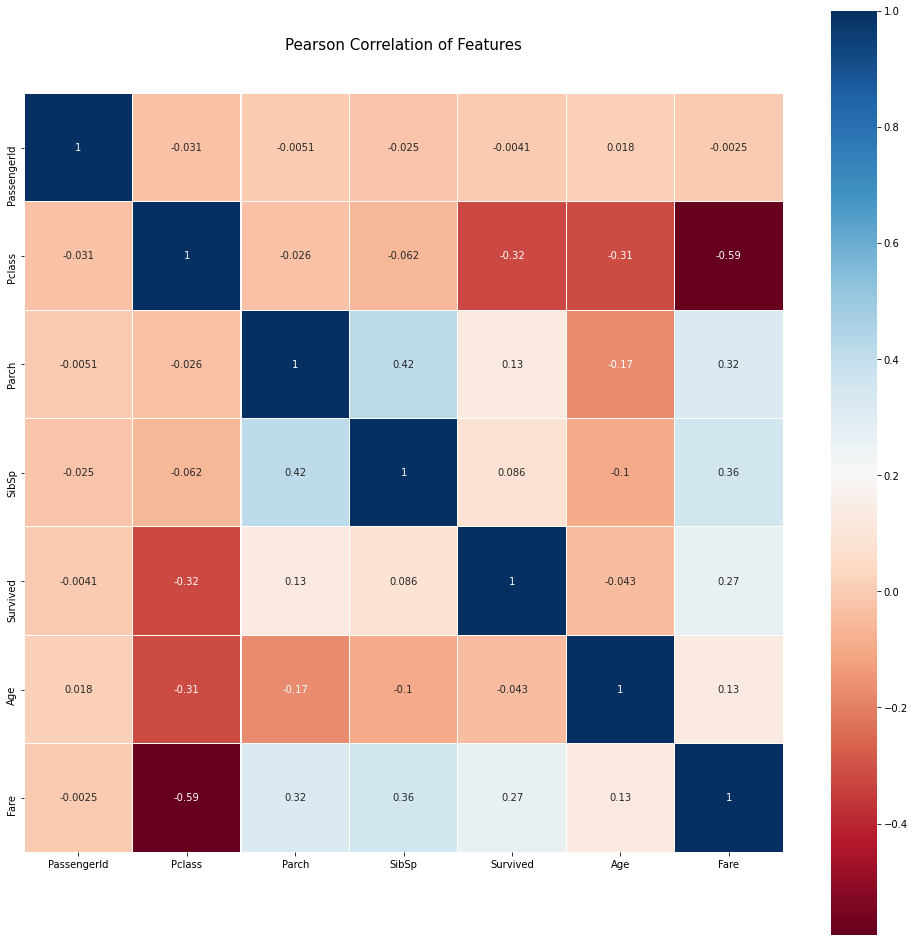

In [3]:
colormap = plt.cm.RdBu
plt.figure(figsize=(17,17))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_1.corr(method='kendall') ,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# - Clean Data

In [4]:
def clean(df):
    
    df = pd.DataFrame(df)
    df.Embarked = [ 0 if i == 'S' else 1 if i == 'C' else 2 for i in df.Embarked]
    df.Sex = [1 if i == "male" else 0 for i in df.Sex]
    df[df.Embarked.isna()].Embarked = int(df.Embarked.mean())
    
    ### Fare
    df.loc[df['Fare'].isna(), 'Fare'] = df.Fare.mean() 
    #df.loc[ df['Fare'] <= 7.91, 'Fare'] 						        = 0
    #df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    #df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    #df.loc[ df['Fare'] > 31, 'Fare'] 							        = 3
    #df['Fare'] = df['Fare'].astype(int)
    #df.Fare = [np.intc(float(str(round(value, 5)).replace('.', ''))) for value in df.Fare]
    
    return df
    
df_2 = clean(df_1)
test_1 = clean(test)

In [5]:
def clean_ticket(df):
    Ticket = pd.DataFrame([ i.split(' ') for i in df.Ticket])
    Ticket.columns = ['Type', 'Sub', 'Num']

    a = []
    b = []
    c = []
    for i, k, j in zip(Ticket.Type, Ticket.Sub, Ticket.Num):
        try:
            c.append(int(i))
            b.append('ZZZ')
            a.append('ZZZ')
        except:
            try:
                c.append(int(k))
                b.append('ZZZ')
                a.append(i)
            except:
                c.append(j)
                b.append(k)
                a.append(i)

    dic = {
        'Tck1': a,
        'Tck2': b,
        'Tck3': c
    }

    Ticket = (pd.DataFrame(dic))
    Ticket.loc[Ticket['Tck3'].isna(), 'Tck3'] = 0
    Ticket.loc[Ticket['Tck2'].isna(), 'Tck2'] = 'NF'
    Ticket.Tck3 = Ticket.Tck3.astype(int)
    
    a_rang = np.arange(0, Ticket.groupby('Tck1').count().shape[0])
    
    a_dic = {
        'inx': Ticket.groupby('Tck1').count().index,
        'val': a_rang
    }
    
    a_dic = pd.DataFrame(a_dic)
    Ticket_a = []

    for i in Ticket.Tck1:
        for j, k in zip(a_dic.inx, a_dic.val):
            if i == j:
                Ticket_a.append(k)

    Ticket.Tck1 = Ticket_a
    
    b_rang = np.arange(0, Ticket.groupby('Tck2').count().shape[0])
    
    b_dic = {
    'inx': Ticket.groupby('Tck2').count().index,
    'val': b_rang
    }
    b_dic = pd.DataFrame(b_dic)
    Ticket_b = []

    for i in Ticket.Tck2:
        for j, k in zip(b_dic.inx, b_dic.val):
            if i == j:
                Ticket_b.append(k)

    Ticket.Tck2 = Ticket_b
    
    df = df.join(Ticket)
    df = df.drop(columns='Ticket')
    
    return df

df_2 = clean_ticket(df_2)
test_1 = clean_ticket(test_1)

In [6]:
df_2

,PassengerId,Name,Pclass,Sex,Parch,SibSp,Survived,Age,Cabin,Fare,Embarked,Tck1,Tck2,Tck3
0,892,"Kelly, Mr. James",3,1,0,0,NaN,34.5,NaN,7.8292,2,50,3,330911
0,1,"Braund, Mr. Owen Harris",3,1,0,1,0.0,22.0,NaN,7.2500,0,50,3,330911
1,893,"Wilkes, Mrs. James (Ellen Needs)",3,0,0,1,NaN,47.0,NaN,7.0000,0,50,3,363272
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,0,1,1.0,38.0,C85,71.2833,1,50,3,363272
2,894,"Myles, Mr. Thomas Francis",2,1,0,0,NaN,62.0,NaN,9.6875,2,50,3,240276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,"Montvila, Rev. Juozas",2,1,0,0,0.0,27.0,NaN,13.0000,0,50,3,36209
887,888,"Graham, Miss. Margaret Edith",1,0,0,0,1.0,19.0,B42,30.0000,0,50,3,2666
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",3,0,2,1,0.0,NaN,NaN,23.4500,0,50,3,323592
889,890,"Behr, Mr. Karl Howell",1,1,0,0,1.0,26.0,C148,30.0000,1,50,3,315089


In [7]:
test_1.head(50)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Tck1,Tck2,Tck3
0,892,3,"Kelly, Mr. James",1,34.5,0,0,7.8292,NaN,2,34,1,330911
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,7.0000,NaN,0,34,1,363272
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,9.6875,NaN,2,34,1,240276
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,8.6625,NaN,0,34,1,315154
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,12.2875,NaN,0,34,1,3101298
5,897,3,"Svensson, Mr. Johan Cervin",1,14.0,0,0,9.2250,NaN,0,34,1,7538
6,898,3,"Connolly, Miss. Kate",0,30.0,0,0,7.6292,NaN,2,34,1,330972
7,899,2,"Caldwell, Mr. Albert Francis",1,26.0,1,1,29.0000,NaN,0,34,1,248738
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,18.0,0,0,7.2292,NaN,1,34,1,2657
9,901,3,"Davies, Mr. John Samuel",1,21.0,2,0,24.1500,NaN,0,3,1,48871


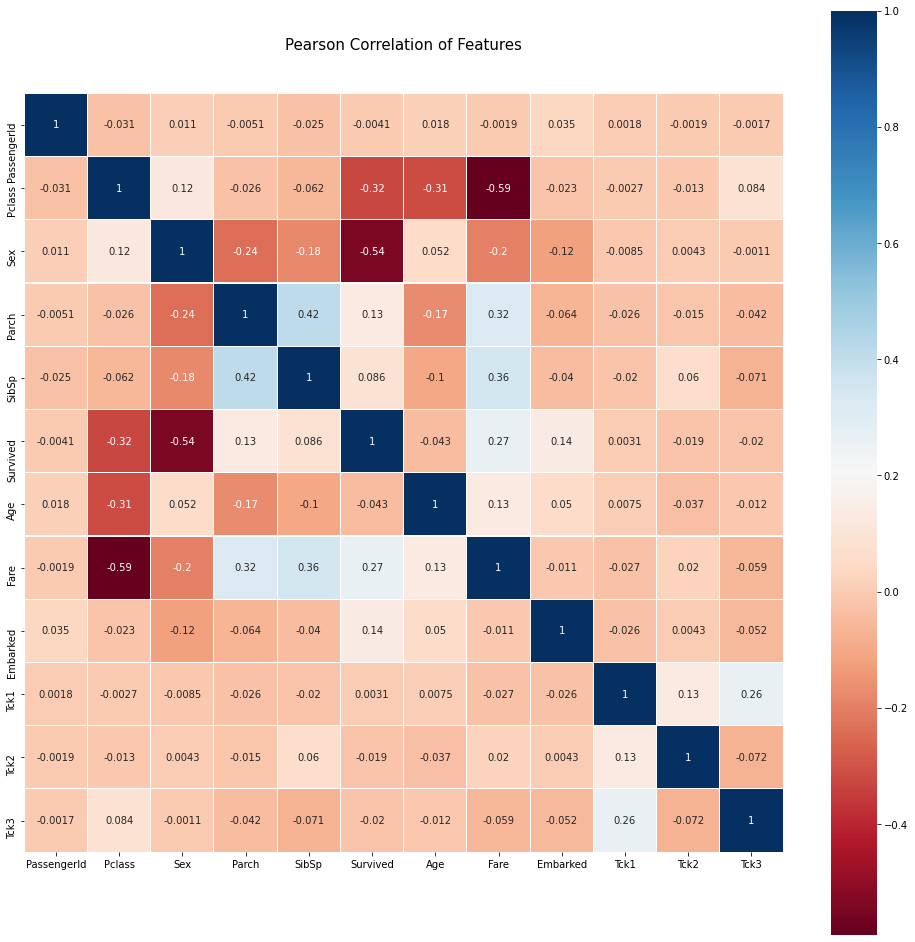

In [8]:
# df_2[(df_2.Cabin.isna()) & (df_2.Pclass == 1)].loc[:, ['Parch', 'SibSp' ,'Cabin', 'Pclass', 'Fare', 'Embarked', 'Ticket', 'Name']].sort_values(by='Embarked').head(50)

colormap = plt.cm.RdBu
plt.figure(figsize=(17,17))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_2.corr(method='kendall') ,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    1309 non-null int64
Name           1309 non-null object
Pclass         1309 non-null int64
Sex            1309 non-null int64
Parch          1309 non-null int64
SibSp          1309 non-null int64
Survived       891 non-null float64
Age            1046 non-null float64
Cabin          295 non-null object
Fare           1309 non-null float64
Embarked       1309 non-null int64
Tck1           1309 non-null int64
Tck2           1309 non-null int64
Tck3           1309 non-null int64
dtypes: float64(3), int64(9), object(2)
memory usage: 153.4+ KB


# - Cabin Columns

In [10]:
def clean_cabin(df, drop, na):
    df = pd.DataFrame(df)
    
    if (na == 1):
        df_cabin = df[~df.Cabin.isna()]
        df_cabin.Cabin = [ord(i[0]) - 65 if type(i) != float else int(i) - 28 for i in df_cabin.Cabin]
        df_cabin.Cabin = [ 0 if i in [0, 1, 2, 3] else 1 for i in df_cabin.Cabin]
    else:
        df_cabin = df[df.Cabin.isna()]

    y = df_cabin.Cabin
    x = df_cabin.drop(columns=drop)
    
    return [x, y]
    
def predict_cabin(df, test=0):
    df = pd.DataFrame(df)
    
    # Trein DataSet -> pd.read_csv('./train.csv')
    # Cleaning DataSet
    drop_train = ['PassengerId', 'Survived', 'Age', 'Name', 'Cabin']
    x_train, y_train = clean_cabin(df, drop_train, 1)  
    
    # Predict train DataSet
    x_train_aux, x_test_aux, y_train_aux, y_test_aux = train_test_split(x_train, y_train, test_size=0.30, random_state=337)
    clf = GradientBoostingClassifier()
    clf.fit(x_train_aux, y_train_aux)
    y_pred = clf.predict(x_test_aux)

    # Predict test DataSet
    x_df_train, y_df_train = clean_cabin(df, drop_train, 0)  
    df_train = clf.predict(x_df_train) 
    
    # Predict final DataSet -> pd.read_csv('./test.csv')
    drop_test = ['PassengerId', 'Age', 'Name', 'Cabin']
    x_df_test, y_df_test = clean_cabin(test, drop_test, 0)
    df_test = clf.predict(x_df_test)
    
    # join DataSet
    df.loc[~df['Cabin'].isna(), 'Cabin'] = y_train
    df.loc[df['Cabin'].isna(), 'Cabin'] = df_train
    
    useless, y_notna = clean_cabin(test, drop_test, 1)
    test.loc[~test['Cabin'].isna(), 'Cabin'] = y_notna
    test.loc[test['Cabin'].isna(), 'Cabin'] = df_test

    print(accuracy_score(y_pred,y_test_aux ))
    
    return [df, test]
    
df_3, test_2 = predict_cabin(df_2, test_1)

0.9101123595505618


/home/ds_magico/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ds_magico/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# - AGE Column

### Data cleaning AGE

In [11]:
Miss = [int(y) for y in df_3[(df_3.Name.str.contains('Miss', na=False))].Age.describe()[2:8]]
Mrs = [int(y) for y in df_3[(df_3.Name.str.contains('Mrs', na=False))].Age.describe()[2:8]]
Mr = [int(y) for y in df_3[(df_3.Name.str.contains('Mr', na=False))].Age.describe()[2:8]]
Master = [int(y) for y in df_3[(df_3.Name.str.contains('Master', na=False))].Age.describe()[2:8]]
Outer = [int(y) for y in df_3[~(df_3.Name.str.contains('Miss|Mrs|Master|Mr', na=False))].Age.describe()[2:8]]

def filterAge(title):

    describe = []
    if('Master' in str(title)):
        describe = Master
        li_title = [1]
    elif('Mrs' in str(title)):
        describe = Mrs
        li_title = [5]
    elif('Mr' in str(title)):
        describe = Mr
        li_title = [2]
    elif('Miss' in str(title)):
        describe = Miss
        li_title = [3]
    else :
        describe = Outer
        li_title = [4]
        
    return [describe, li_title]

In [12]:
age = pd.DataFrame([filterAge(i) for i in df_3.Name])
age.columns = ['x', 'y']
age.y = [ str(i)[1: -1] for i in age.y]
age = age.join(pd.DataFrame([str(i)[1: -1].split(',') for i in age.x]))
age = age.drop(columns=['x'])
age.columns = ['Title', 'Min', 'Per_25', 'Per_50', 'Pre_75', 'Max', 'Std']
# age.Max = [i[:-1] for i in age.Max]
# age.Title = [i[-1:] for i in age.Title]

In [13]:
age = age.astype(int)
df_3 = df_3.join(age)

### Predict Age Train/Test

In [14]:
# Organizando modelos de treino e teste
dfAgeTrain = df_3[df_3.Age.notna()]    # DataFrame que possui idades
dfAgeTest = df_3[df_3.Age.isna()]      # DataFrame que não possui idades

# DataFrame de Treinamento
y_ageTrain = dfAgeTrain['Age']

# target
y_ageTrain = pd.Series([np.intc(value) for value in y_ageTrain])
# Data
x_ageTrain = dfAgeTrain.drop(columns=['PassengerId', 'Name', 'Age', 'Survived'])

# DataFrame a ser previsto
x_ageTest = dfAgeTest.drop(columns=['PassengerId', 'Name', 'Age', 'Survived'])

x_train_ageTrain, x_test_ageTrain, y_train_ageTrain, y_test_ageTrain = train_test_split(x_ageTrain, y_ageTrain, test_size=0.3, random_state=337)

In [15]:
dfAgeTest

,PassengerId,Name,Pclass,Sex,Parch,SibSp,Survived,Age,Cabin,Fare,...,Tck1,Tck2,Tck3,Title,Min,Per_25,Per_50,Pre_75,Max,Std
5,6,"Moran, Mr. James",3,1,0,0,0.0,NaN,1,8.4583,...,50,3,7538,3,12,0,15,22,30,63
10,902,"Ilieff, Mr. Ylio",3,1,0,0,NaN,NaN,1,7.8958,...,50,3,349220,2,12,11,24,30,41,80
17,18,"Williams, Mr. Charles Eugene",2,1,0,0,1.0,NaN,1,13.0000,...,50,3,2692,5,12,14,26,35,46,76
19,20,"Masselmani, Mrs. Fatima",3,0,0,0,1.0,NaN,1,7.2250,...,50,3,2696,5,12,14,26,35,46,76
22,914,"Flegenheim, Mrs. Alfred (Antoinette)",1,0,0,0,NaN,NaN,0,31.6833,...,22,3,17598,2,12,11,24,30,41,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,"Razi, Mr. Raihed",3,1,0,0,0.0,NaN,1,7.2292,...,50,3,345769,2,12,11,24,30,41,80
863,864,"Sage, Miss. Dorothy Edith ""Dolly""",3,0,2,8,0.0,NaN,1,69.5500,...,50,3,33638,1,4,0,2,4,9,14
868,869,"van Melkebeke, Mr. Philemon",3,1,0,0,0.0,NaN,0,9.5000,...,12,3,34651,2,12,11,24,30,41,80
878,879,"Laleff, Mr. Kristo",3,1,0,0,0.0,NaN,1,7.8958,...,50,3,19952,2,12,11,24,30,41,80


In [16]:
clf_age = GradientBoostingRegressor()
clf_age.fit(x_train_ageTrain, y_train_ageTrain)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
y_pred = clf_age.predict(x_test_ageTrain)

In [18]:
y_pred = [np.intc(value) for value in np.array(y_pred)]
dic = {"Real_age": np.array(y_test_ageTrain), 
       "Pred_age": y_pred
      }

pred = pd.DataFrame(dic)

pred['Erro'] = pred['Real_age'] - pred['Pred_age']

In [21]:
# Accuracy
pred['Erro'].describe()

count    314.000000
mean      -0.557325
std       12.605778
min      -35.000000
25%       -8.000000
50%       -2.000000
75%        6.000000
max       44.000000
Name: Erro, dtype: float64

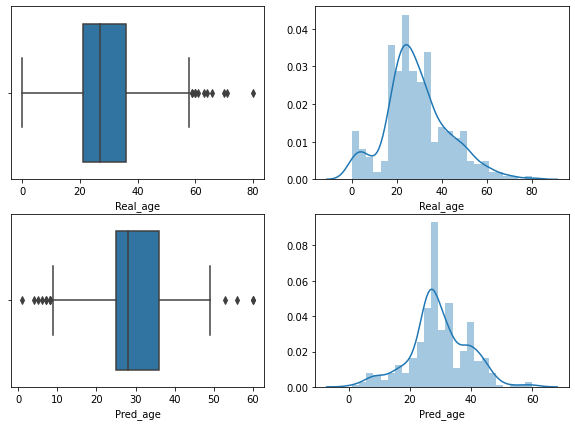

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

sns.boxplot(ax=axes[0][0], x='Real_age', data=pred)
sns.boxplot(ax=axes[1][0], x='Pred_age', data=pred)
sns.distplot(pred['Real_age'], ax=axes[0][1], bins=25)
sns.distplot(pred['Pred_age'], ax=axes[1][1], bins=25)

In [23]:
# plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
#          stacked=True, color = ['g','r'],label = ['Survived','Dead'])

NameError: name 'data1' is not defined

### Predict Age Real

In [24]:
model = clf_age.predict(x_ageTest)
model = [np.intc(x) for x in model]
dfAgeTest.Age = model

/home/ds_magico/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Survived

In [25]:
df_4 = pd.concat([dfAgeTest, dfAgeTrain]).sort_values(by='PassengerId')

df_4.Age = df_4.Age.astype(int) #[np.intc(i) for i in df_4.Age]

### col family_sex

### col family_size
# df_4['Family_size'] = [ i for i in df_4.SibSp + df_4.Parch]

### col sex
# sex = [[1, 0] if 1 == i else [0, 1] for i in df_4.Sex]
# sex = pd.DataFrame(sex)
# sex.columns = ['Male', 'Female']
# df_4 = df_4.join(sex)

### col names_num
# df_4['Names_num'] = [len(i.split()) for i in df_4.Name]

### col Age
# df_4.loc[ df_4['Age'] <= 23, 'Age'] = 0
# df_4.loc[(df_4['Age'] > 23) & (df_4['Age'] <= 34), 'Age'] = 1
# # df_4.loc[(df_4['Age'] > 28) & (df_4['Age'] <= 37), 'Age'] = 2
# # df_4.loc[(df_4['Age'] > 31) & (df_4['Age'] <= 41), 'Age'] = 3
# df_4.loc[ df_4['Age'] > 34, 'Age'] = 2;

### col Alone, max 2 
# 0 if i < 1 else 1 if i == 1 else 2
df_4['Alone'] = [0 if i == 0 else 1 for i in df_4.SibSp + df_4.Parch]


#
df_4.Cabin = df_4.Cabin.astype(int)
df_4 = df_4[df_4.Embarked < 6]

In [26]:
pd.crosstab( df_4.Embarked, df_4.Survived, normalize='all') * 100

Survived,0.0,1.0
Embarked,,
0,47.923681,24.354658
1,8.417508,10.437710
2,5.274972,3.591470


In [27]:
df_4.describe()

,PassengerId,Pclass,Sex,Parch,SibSp,Survived,Age,Cabin,Fare,Embarked,...,Tck2,Tck3,Title,Min,Per_25,Per_50,Pre_75,Max,Std,Alone
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,...,1309.000000,1.309000e+03,1309.000000,1309.000000,1309.000000,1309.00000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,2.294882,0.644003,0.385027,0.498854,0.383838,29.594347,0.653170,33.295479,0.397250,...,2.967914,2.748296e+05,2.661574,11.559969,8.827349,21.40107,27.974026,37.987013,72.042781,0.396486
std,378.020061,0.837836,0.478997,0.865560,1.041658,0.486592,13.489989,0.476143,51.738879,0.656321,...,0.301186,6.211512e+05,1.147753,1.824599,5.575242,6.20129,7.348319,8.885303,15.508102,0.489354
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,1.000000,4.000000,0.000000,2.00000,4.000000,9.000000,14.000000,0.000000
25%,328.000000,2.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,7.895800,0.000000,...,3.000000,1.369500e+04,2.000000,12.000000,0.000000,15.00000,22.000000,30.000000,63.000000,0.000000
50%,655.000000,3.000000,1.000000,0.000000,0.000000,0.000000,28.000000,1.000000,14.454200,0.000000,...,3.000000,1.104650e+05,2.000000,12.000000,11.000000,24.00000,30.000000,41.000000,80.000000,0.000000
75%,982.000000,3.000000,1.000000,0.000000,1.000000,1.000000,37.000000,1.000000,31.275000,1.000000,...,3.000000,3.470540e+05,3.000000,12.000000,11.000000,24.00000,30.000000,41.000000,80.000000,1.000000
max,1309.000000,3.000000,1.000000,9.000000,8.000000,1.000000,80.000000,1.000000,512.329200,2.000000,...,3.000000,3.101315e+06,5.000000,12.000000,23.000000,32.00000,44.000000,53.000000,80.000000,1.000000


(array([[ 34.,  15.,  64.,  97.,  65.,  30.,  25.,  11.,   0.,   1.],
        [ 52.,  43., 182., 287., 141.,  95.,  51.,  27.,  11.,   2.]]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <a list of 2 Lists of Patches objects>)

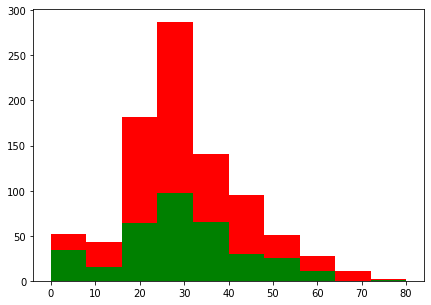

In [28]:
plt.figure(figsize=(7, 5))
plt.hist(x = [df_4[df_4['Survived']==1]['Age'], df_4[df_4['Survived']==0]['Age']], stacked=True, color = ['g','r'],label = ['Survived','Dead'])

In [29]:
# fig, qaxis = plt.subplots(1,3,figsize=(14,12))

# sns.barplot(x = 'Sex', y = 'Survived', data=df_4, ax = qaxis[0])
# axis1.set_title('Sex vs Embarked Survival Comparison')

# sns.barplot(x = 'Sex', y = 'Survived', data=df_4, ax  = qaxis[1])
# axis1.set_title('Sex vs Pclass Survival Comparison')


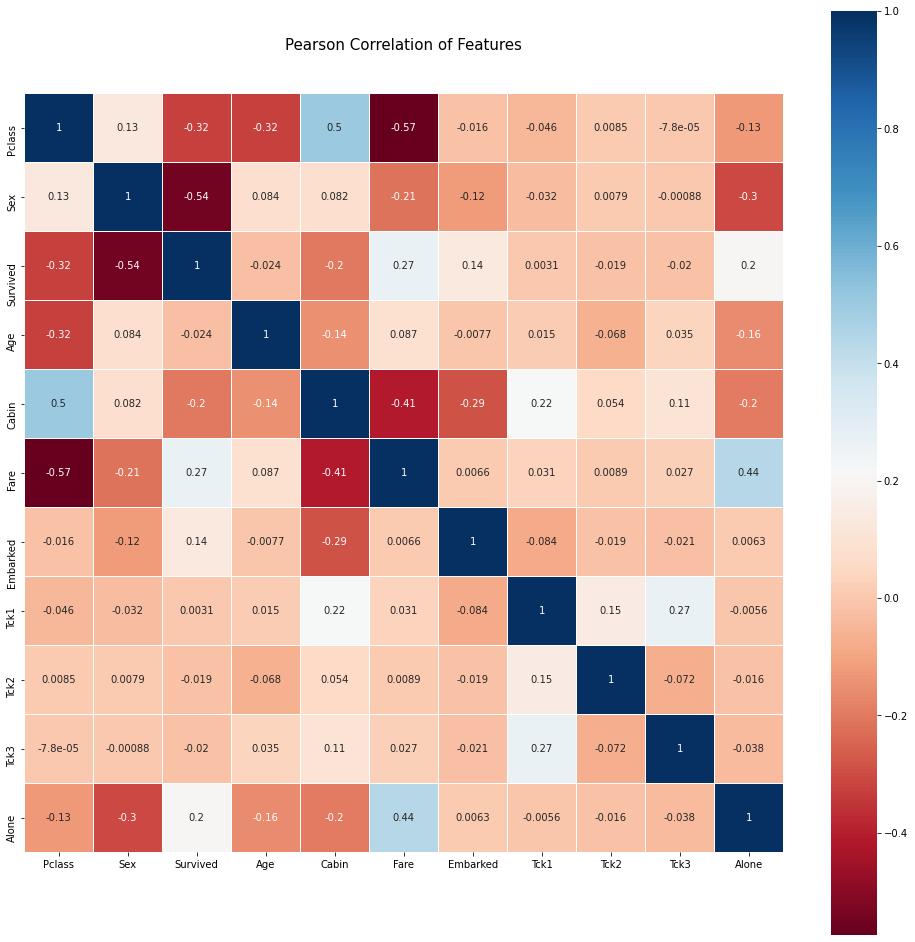

In [30]:
df_4 = df_4[~df_4.Survived.isna()].drop(columns=['Std', 'Min' ,'Per_25', 'Per_50', 'Pre_75', 'Max', 'PassengerId', 'Name', 'Title', 'SibSp', 'Parch'])
df_4.Survived = df_4.Survived.astype(int)
# df_4.Survived = [ np.intc(i) for i in df_4.Survived]

y = df_4.Survived
x = df_4.drop(columns='Survived')

colormap = plt.cm.RdBu
plt.figure(figsize=(17,17))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_4.astype(float).corr(method='kendall') ,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

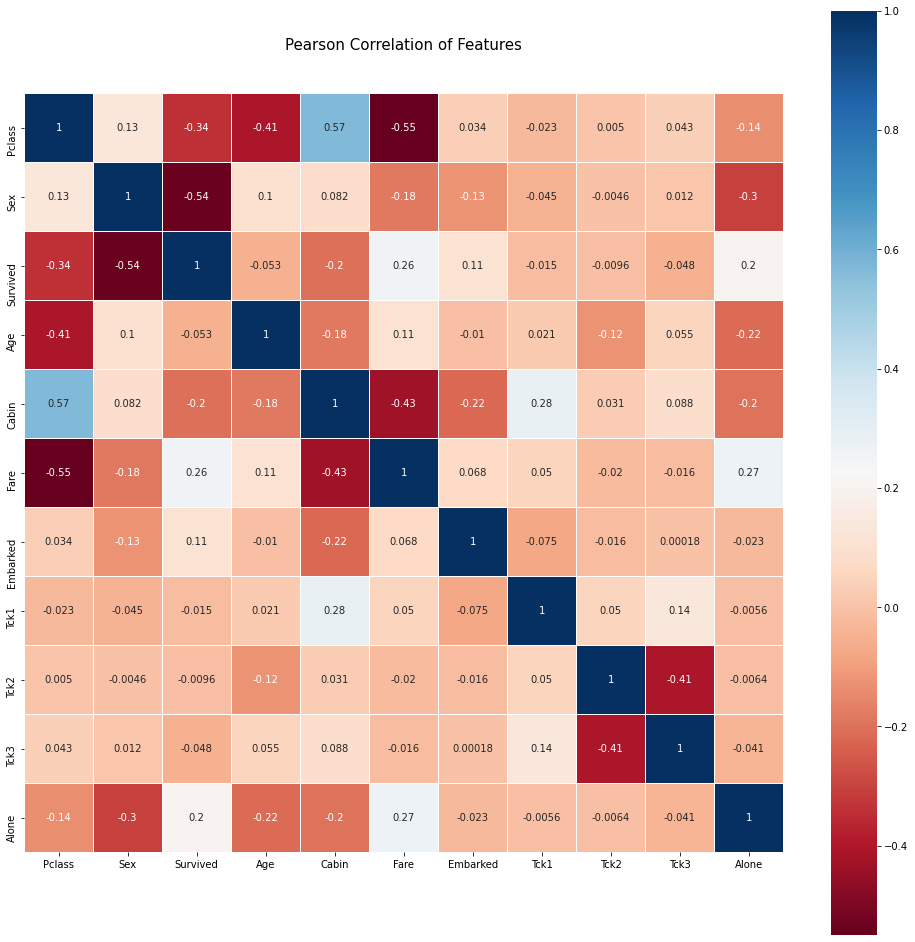

In [31]:
colormap = plt.cm.RdBu
plt.figure(figsize=(17,17))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_4.astype(float).corr() ,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=337)

# RandomForestClassifier
# GaussianProcessClassifier
# GradientBoostingClassifier
# AdaBoostClassifier
# RidgeClassifierCV
# RidgeClassifier
# BaggingClassifier
# ExtraTreesClassifier
# RandomForestClassifier
# BernoulliNB
# LinearDiscriminantAnalysis
# XGBClassifier 

# import autosklearn.classification
# cls = autosklearn.classification.AutoSklearnClassifier()
# cls.fit(x_train, y_train)

clf = XGBClassifier(
#         learning_rate = 0.15,
#          n_estimators= 2000,
#          max_depth= 1,
#          min_child_weight= 1,
#          #gamma=1,
#          gamma=0.9,                        
#          subsample=0.79,
#          colsample_bytree=0.8,
#          objective= 'binary:logistic',
#          nthread= -1,
#          scale_pos_weight=1
      )
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred) * 100

80.59701492537313

In [34]:
df_4

,Pclass,Sex,Survived,Age,Cabin,Fare,Embarked,Tck1,Tck2,Tck3,Alone
0,3,1,0,22,1,7.2500,0,50,3,330911,1
1,1,0,1,38,0,71.2833,1,50,3,363272,1
2,3,0,1,26,1,7.9250,0,50,3,240276,0
3,1,0,1,35,0,53.1000,0,50,3,315154,1
4,3,1,0,35,1,8.0500,0,50,3,3101298,0
...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,0,27,1,13.0000,0,50,3,36209,0
887,1,0,1,19,0,30.0000,0,50,3,2666,0
888,3,0,0,17,1,23.4500,0,50,3,323592,1
889,1,1,1,26,0,30.0000,1,50,3,315089,0
